In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2

In [3]:
import random

In [4]:
import copy

In [ ]:
def particle_filter(motions, measurements, N=500): # I know it's tempting, but don't change N!
	# --------
	#
	# Make particles
	# 

	p = []
	for i in range(N):
		r = robot()
		r.set_noise(bearing_noise, steering_noise, distance_noise)
		p.append(r)

	# --------
	#
	# Update particles
	#     

	for t in range(len(motions)):

		# motion update (prediction)
		p2 = []
		for i in range(N):
			p2.append(p[i].move(motions[t]))
		p = p2

		# measurement update
		w = []
		for i in range(N):
			w.append(p[i].measurement_prob(measurements[t]))

		# resampling
		p3 = []
		index = int(random.random() * N)
		beta = 0.0
		mw = max(w)
		for i in range(N):
			beta += random.random() * 2.0 * mw
			while beta > w[index]:
				beta -= w[index]
				index = (index + 1) % N
			p3.append(p[index])
		p = p3

	return get_position(p)

# generate object measurement

model:

$$x_t = x_{t-1} + \dot{x}_{t-1}\cdot\nabla t \tag{1}$$
$$y_t = x_t \tag{2}$$

matrix expression:

$$
\left[
\begin{matrix}
     x_t      \\
\dot{x_{t-1}}
\end{matrix}
\right]
=
\left[
\begin{matrix}
1 & \nabla t \\
0 & 1
\end{matrix}
\right]
\left[
\begin{matrix}
x_{t-1} \\
\dot{x}_{t-1}
\end{matrix}
\right] \tag{3}
$$

$$
\left[
\begin{matrix}
y_t
\end{matrix}
\right]
=
\left[
\begin{matrix}
1 &
0
\end{matrix}
\right]
\left[
\begin{matrix}
x_t \\
\dot{x}_{t-1}
\end{matrix}
\right] \tag{4}
$$

In [5]:
def get_random_number_by_var(var):
    std = np.sqrt(var)
    return np.random.randn(*var.shape) * std

In [6]:
def get_prob(predict, measurement, var = 1):
    delt = predict - measurement
    return np.exp(-0.5*(delt/var)**2)

In [7]:
get_prob(30, 30)

1.0

# 有两个，一个是测量噪声Q，一个状态不确定性噪声R

In [8]:
np.random.seed(112)
delt_t = 0.03
steps = 1000

x_0 = 10
dx_0 = 0.1
X_0 = np.array([[x_0], [dx_0]])

R = np.array([[0.5], [0.01]])
Q = np.array([[10]])

f = np.array([[1, delt_t], [0, 1]])
h = np.array([[1, 0]])

# true state
X = []
Y = []
Y_n = []

X_t_1 = X_0
for i in range(0, steps):
    X_t = f.dot(X_t_1)
    X_t = X_t + get_random_number_by_var(R)
    Y_t = h.dot(X_t)
    Y_t_n = Y_t + get_random_number_by_var(Q)
    X_t_1 = X_t
    
    X.append(X_t)
    Y.append(Y_t)
    Y_n.append(Y_t_n)

In [9]:
measure_real = np.vstack(Y)
measure_noise = np.vstack(Y_n)

In [10]:
measure_real.shape, measure_noise.shape

((1000, 1), (1000, 1))

Text(0.5,1,'state and state with noise')

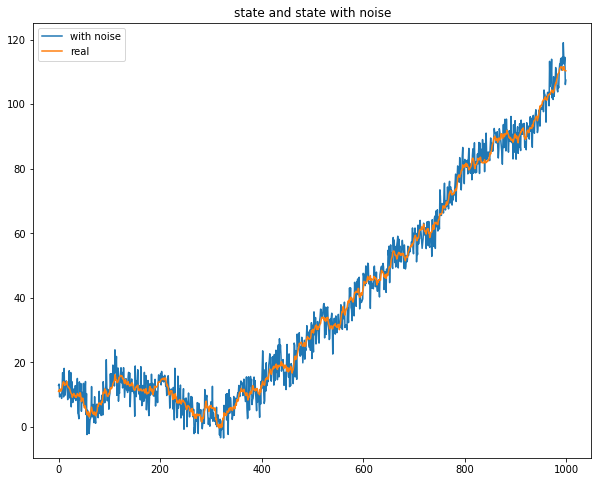

In [11]:
plt.figure(figsize=[10, 8])
plt.plot(measure_noise)
plt.plot(measure_real)
plt.legend(['with noise', 'real'])
plt.title('state and state with noise')

# Partical

In [12]:
class Partical:
    def __init__(self, R, Q, f):
        self.R = R
        self.Q = Q
        self.x = get_random_number_by_var(self.R)
        self.f = f
    
    def predict(self):
        self.x = self.f.dot(self.x) + get_random_number_by_var(self.R)
        p = Partical(self.R, self.Q, self.f)
        p.x = self.x
        return p
        
    def get_position(self):
        return self.x[0].item()

# 要注意抽出的粒子需要深拷贝

In [13]:
partical_num = 200

In [38]:
# init state
partical_list = []
for i in range(partical_num):
    p = Partical(Q=Q, R=R, f=f)
    partical_list.append(p)
# w = [1] * partical_num

filtered = []
for idx, Y_n_t in enumerate(Y_n):
#     if idx > 10:
#         break
    measurement = Y_n_t.item()
    
    # predict
    w = []
    list_new = []
    for p in partical_list:
        p_new = p.predict()
        list_new.append(p_new)
        
        prob = get_prob(predict=p_new.get_position(), measurement=measurement, var=Q.item())
        w.append(prob)
        
    partical_list = list_new

#     # resampling 
#     # Method 1
#     p3 = []
#     index = int(np.random.random() * partical_num)
#     beta = 0.0
#     mw = max(w)
#     for i in range(partical_num):
#         beta += np.random.random() * 2.0 * mw
#         while beta > w[index]:
#             beta -= w[index]
#             index = (index + 1) % partical_num
# #         p3.append(copy.deepcopy(partical_list[index]))
#         p3.append(partical_list[index])
#     partical_list = p3

#     # resampling 
#     # Method 2
    sum_data = sum(w)
    w = [x/sum_data for x in w]
    partical_list = np.random.choice(partical_list, partical_num, p=w)

    estimate = []
    for p in partical_list:
        estimate.append(p.get_position())
    out = np.mean(estimate)
    filtered.append(out)
filtered = np.array(filtered).reshape(-1, 1)

Text(0.5,1,'state and state with noise')

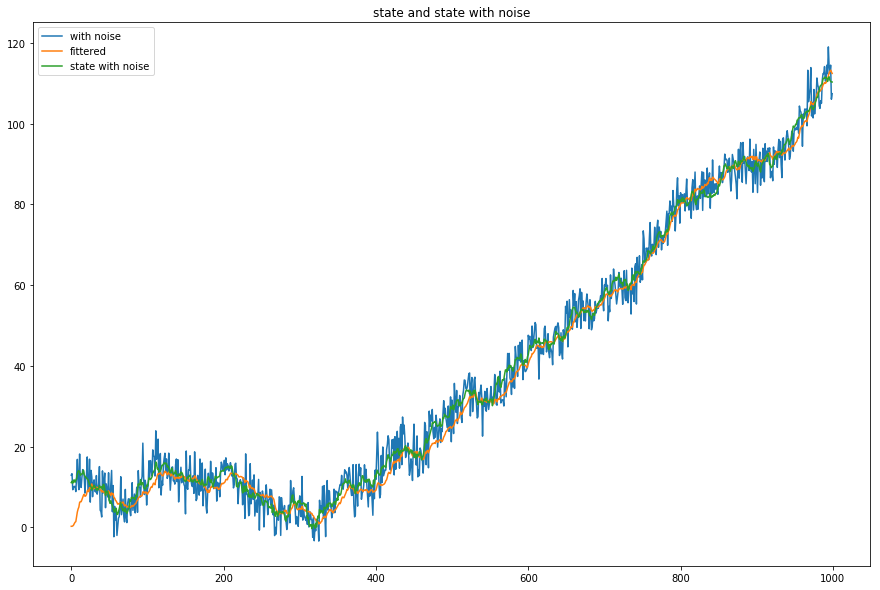

In [39]:
plt.figure(figsize=[15, 10])
plt.plot(measure_noise)
plt.plot(filtered)
plt.plot(measure_real)
plt.legend(['with noise', 'fittered', 'state with noise'])
plt.title('state and state with noise')

In [66]:
measure_noise.shape

(1000, 1)

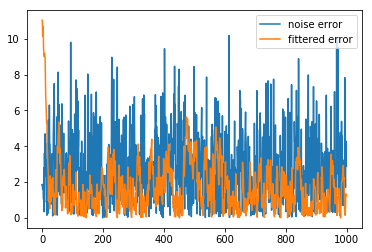

In [68]:
plt.plot(np.abs(measure_noise-measure_real))
plt.plot(np.abs(filtered-measure_real))
plt.legend(['noise error', 'fittered error'], loc='upper right')

In [45]:
np.random.rand()

0.3777371481092462

In [46]:
import copy

In [47]:
class w:
    def __init__(self):
        self.t = 10
    def set_val(self, val):
        self.t = val
    def val(self):
        return self.t
    def __repr__(self):
        return str(self.t)

In [48]:
t = []
a = w()
t.append(copy.deepcopy(a))
t.append(a)

In [49]:
a.set_val(11)

In [50]:
a

11

In [50]:
t

[10, 11]

In [34]:
a[0] = 4

In [35]:
t

[[3], [4]]

In [22]:
q = []
q.append(a)

In [24]:
a[0] = 5

In [25]:
q

[[5]]

In [26]:
t

[[5], [5]]

In [169]:
import cv2

In [170]:
[x for x in dir(cv2) if 'sift' in x.lower()]

['xfeatures2d_SIFT']